## This notebook is used to extract quantitative information from the 14 generic escarpment retreat LEMs. 

## For example, the cross-escaprment profiles and flexural response curves through time can be extracted here (see Methods 3.4.1-3.4.2 for details).

In [2]:
import pygmt
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns

from scripts import extractBasin 

import matplotlib
import matplotlib.pyplot as plt

label_size = 8
matplotlib.rcParams['xtick.labelsize'] = label_size
matplotlib.rcParams['ytick.labelsize'] = label_size
matplotlib.rc('font', size=8)

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

**Before running this notebook, make sure that you have extracted the nc-grids from your goSPL output folder.**

> This is done by running:

```python
python3 build_ncgrids.py -i input-escarpment.yml -o nc-escarpment -s 75
```

where:
    + `input-escarpment.yml`: the goSPL inputfile for a specific model
    + `nc-escarpment`: a specific folder where the new grids will be saved
    + `75`: a integer representing the number of time steps to process (usually set to the number of goSPL outputs)

This script will basically create similar grids as the ones done when running:
  - `exportnc.ipynb`
  - `diversity.ipynb`

(These notebooks are in the`notebooks` folder and you will need to move them to this folder before using them)

This will create 2 sets of netcdf grids for each time step:
  1. a regular nc grid with goSPL outputs (`dataXXX.nc`)
  2. a regular nc grid with morphometrics information (`physioXXX.nc`)

### 2D visualisaiton of escarpment retreat model

Load a netcdf grid from goSPL at a specific time step:

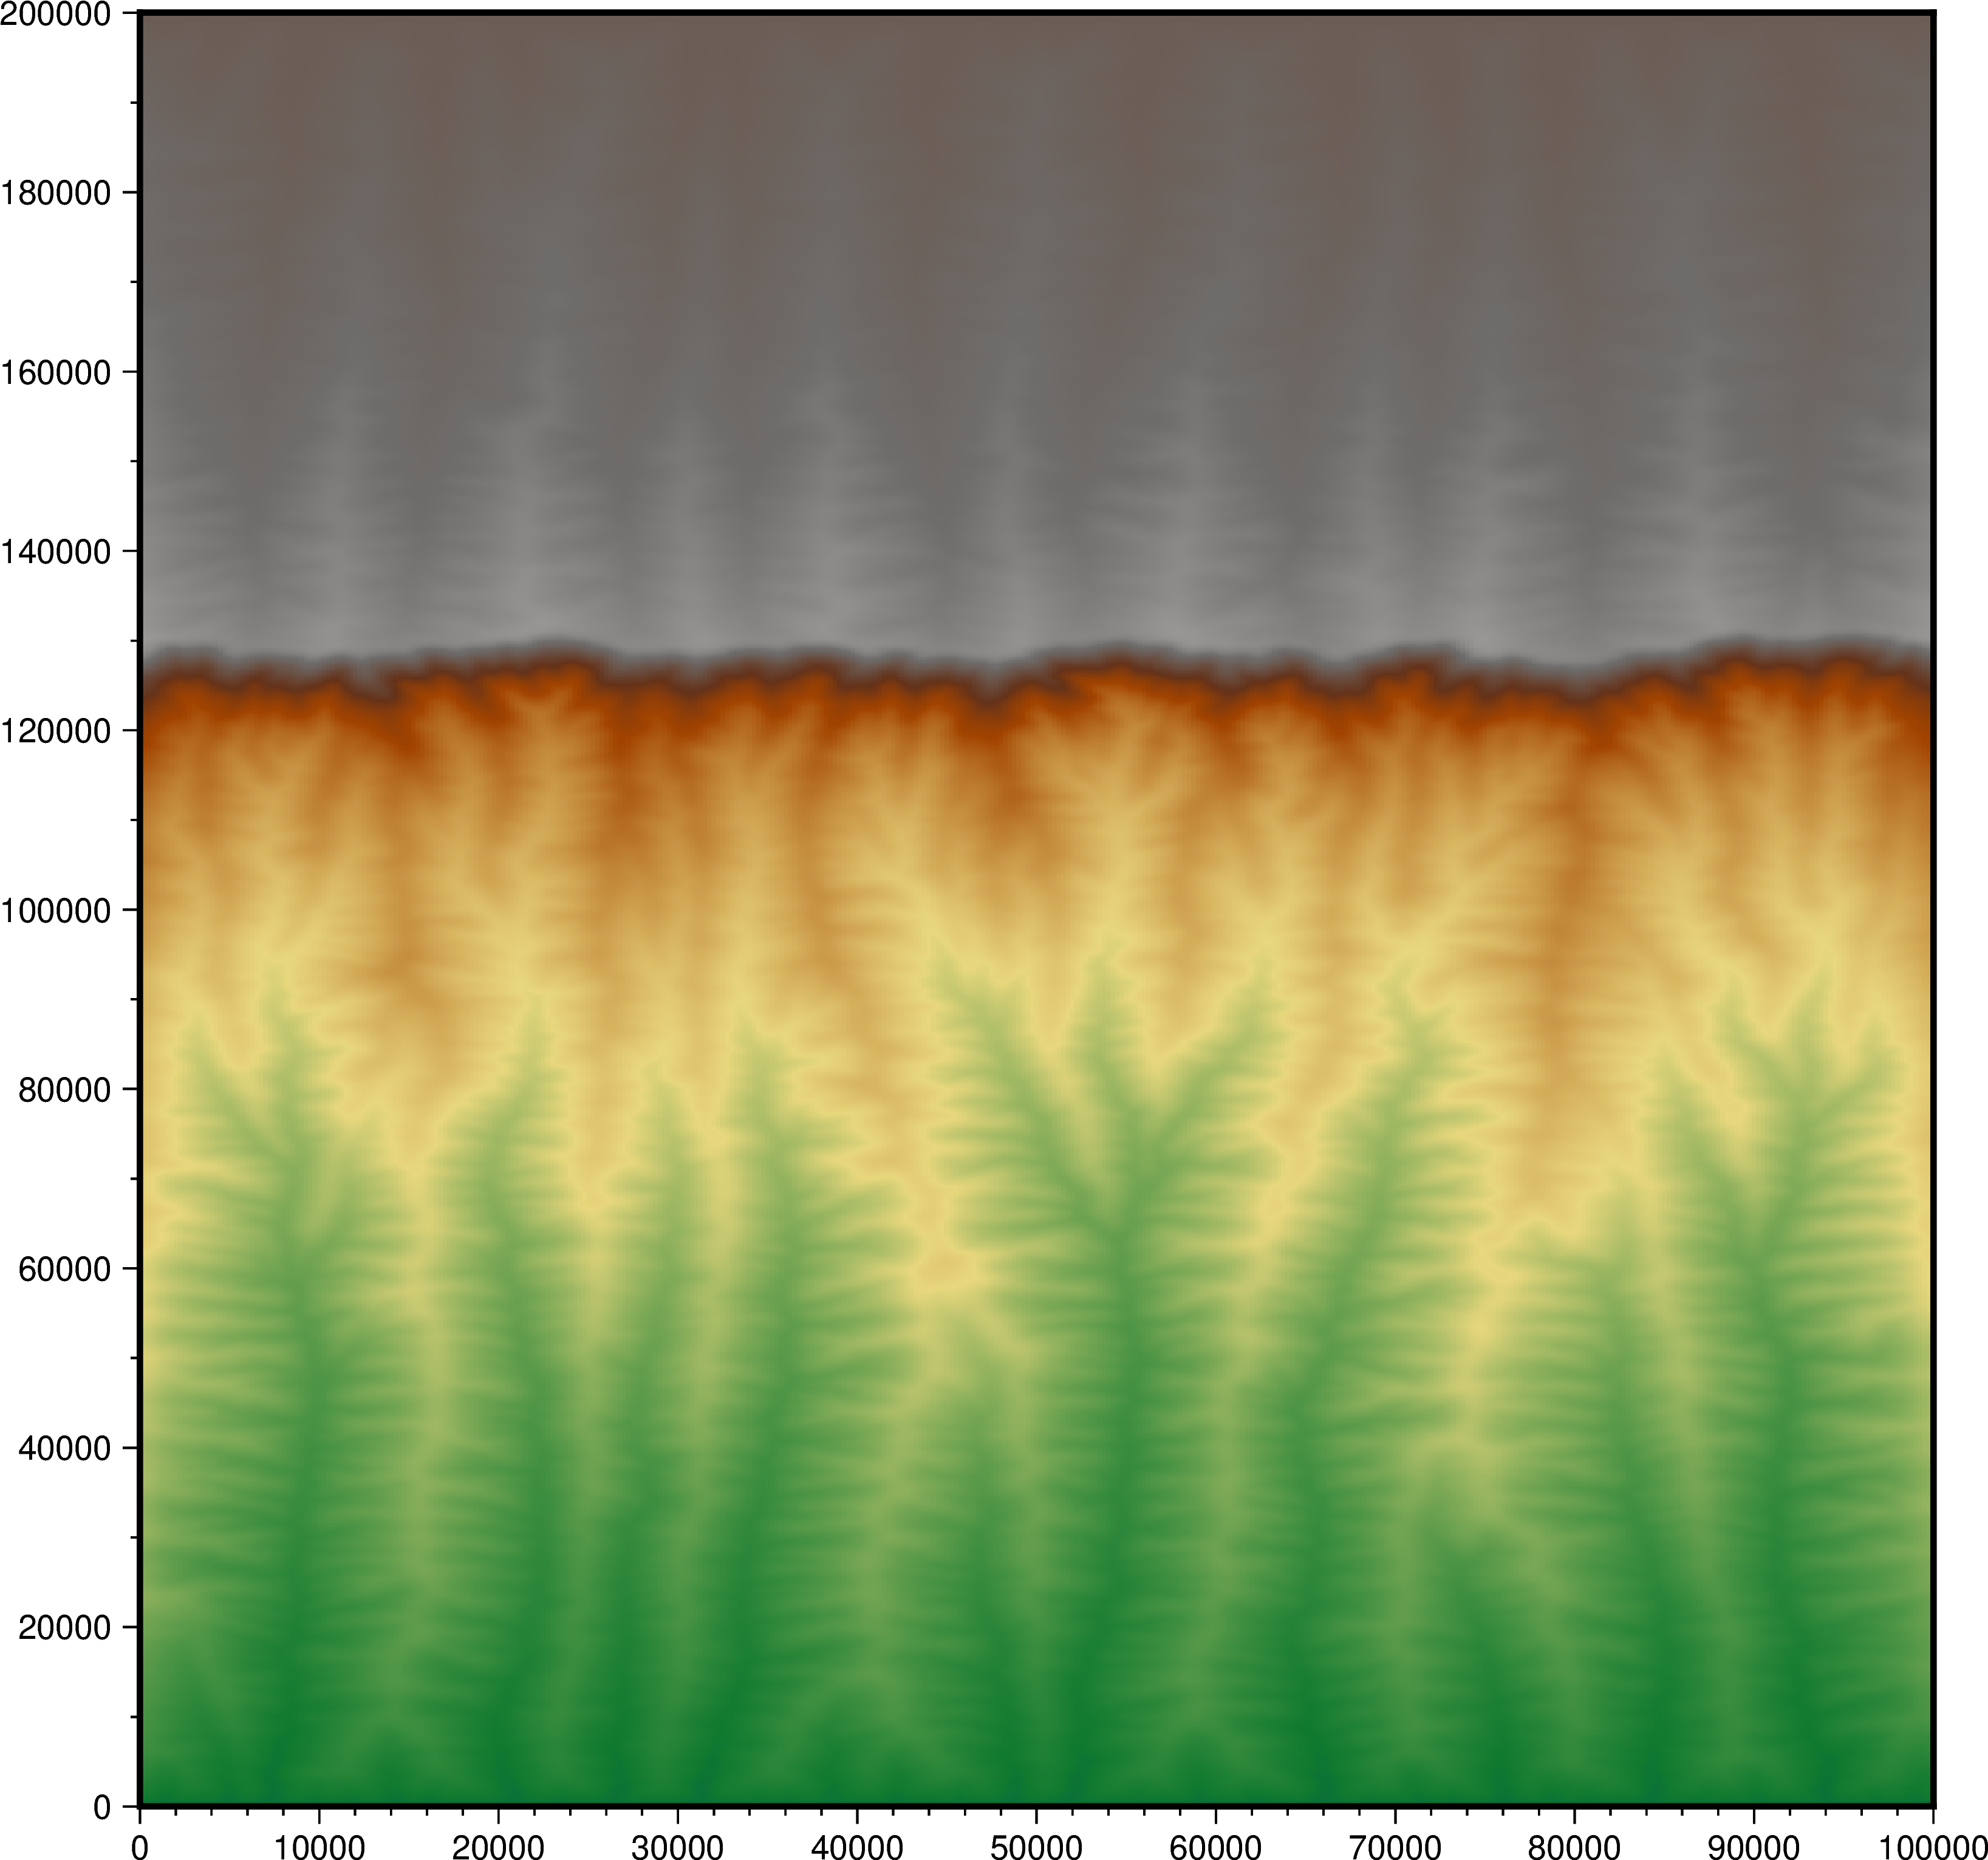

In [4]:
step = 75 # pick time step

# Open netcdf data file for a specific time step
out_path = 'braun_reference/'
dataset = xr.open_dataset(out_path+'data'+str(step)+'.nc')

fig = pygmt.Figure()
with pygmt.config(FONT='8p,Helvetica,black',COLOR_FOREGROUND="white", COLOR_BACKGROUND="white"):
    pygmt.makecpt(cmap="geo", series=[0, 2000]) 
    fig.grdimage(dataset.elevation, cmap=True, shading=False, frame=True)

fig.show(dpi=500, width=500)

### Escarpment retreat (cross-escarpment profile through time)

In [5]:
meands = dataset.mean(dim='x')
maxds = dataset.max(dim='x')
minds = dataset.min(dim='x')

escarpment_pos_mean = meands.elevation.where(meands.elevation==meands.elevation.max(), drop=True).squeeze().y.values
escarpment_pos_max = maxds.elevation.where(maxds.elevation==maxds.elevation.max(), drop=True).squeeze().y.values
escarpment_pos_min = minds.elevation.where(minds.elevation==minds.elevation.max(), drop=True).squeeze().y.values


### Average cross-profile at final time step

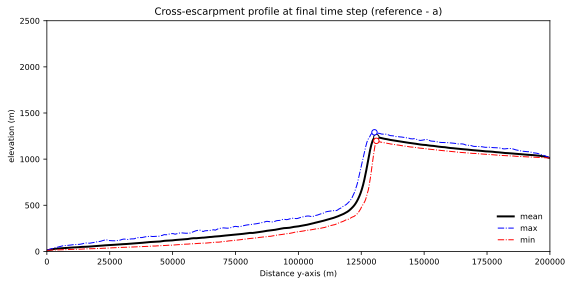

In [6]:
plt.figure(figsize=(8,4))
ax = plt.gca()

meands.elevation.plot(lw=2,c='k',label='mean')
maxds.elevation.plot(lw=1,c='b',ls='-.',label='max')
minds.elevation.plot(lw=1,c='r',ls='-.',label='min')

plt.scatter(escarpment_pos_mean,meands.elevation.max(),c='w',s=30,edgecolors='k',zorder=2)
plt.scatter(escarpment_pos_min,minds.elevation.max(),c='w',s=30,edgecolors='r',zorder=2)
plt.scatter(escarpment_pos_max,maxds.elevation.max(),c='w',s=30,edgecolors='b',zorder=2)

plt.xlabel('Distance y-axis (m)')
plt.ylabel('elevation (m)')
plt.title('Cross-escarpment profile at final time step (reference - a)', size=10)
plt.ylim(0,2500)
plt.xlim(dataset.y.min(),dataset.y.max())
plt.legend(frameon=False, loc="lower right")
plt.tight_layout()
plt.show()

### Evaluate escarpment evolution over time

In [7]:
escpt_mean = []
escpt_max = []
escpt_min = []

escpt_pos_mean = []
escpt_pos_max = []
escpt_pos_min = []

for s in range(1,76):
    # Open netcdf data file for the considered time step
    dataset = xr.open_dataset(out_path+'data'+str(s)+'.nc')
    
    # Get escarpment longitudinal profile information
    meands = dataset.mean(dim='x')
    maxds = dataset.max(dim='x')
    minds = dataset.min(dim='x')
    escpt_mean.append(meands)
    escpt_max.append(maxds)
    escpt_min.append(minds)

    # Get escarpment position
    maxz_mean = meands.elevation.max().values
    maxz_min = minds.elevation.max().values
    maxz_max = maxds.elevation.max().values

    escarpment_pos_mean = meands.elevation.where(meands.elevation==maxz_mean, drop=True).squeeze().y.values
    escarpment_pos_max = maxds.elevation.where(maxds.elevation==maxz_max, drop=True).squeeze().y.values
    escarpment_pos_min = minds.elevation.where(minds.elevation==maxz_min, drop=True).squeeze().y.values
    
    escpt_pos_mean.append([escarpment_pos_mean,maxz_mean])
    escpt_pos_max.append([escarpment_pos_max,maxz_max])
    escpt_pos_min.append([escarpment_pos_min,maxz_min])
    

### Entire escarpment evolution

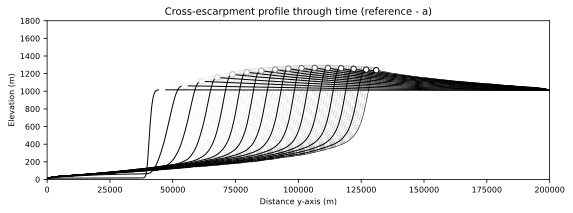

In [8]:
plt.figure(figsize=(8, 3))
ax = plt.gca()

cmap = plt.get_cmap('gray_r', len(escpt_mean) + 1)

# Loop through all time steps for a complete time range representation
for k in range(len(escpt_mean)):
    meands = escpt_mean[k]
    escarpment_pos_mean = escpt_pos_mean[k]
    meands.elevation.plot(lw=1, ls='-.', c=cmap(k), alpha=0.2)
    plt.scatter(escarpment_pos_mean[0], escarpment_pos_mean[1], c='w',
                s=30, edgecolors=cmap(k), zorder=2, alpha=0.2)

# Adjust this loop to plot every 5th time step for emphasis
for k in range(0, len(escpt_mean), 5):
    meands = escpt_mean[k]
    escarpment_pos_mean = escpt_pos_mean[k]
    meands.elevation.plot(lw=1, c='k')
    plt.scatter(escarpment_pos_mean[0], escarpment_pos_mean[1], c='w',
                s=30, edgecolors=cmap(k), zorder=4)

# Manually include the final time step, if necessary
if len(escpt_mean) > 74:
    k = 74
    meands = escpt_mean[k]
    escarpment_pos_mean = escpt_pos_mean[k]
    meands.elevation.plot(lw=0.5, c='k')
    plt.scatter(escarpment_pos_mean[0], escarpment_pos_mean[1], c='w',
                s=30, edgecolors=cmap(k), zorder=4)

plt.xlabel('Distance y-axis (m)')
plt.ylabel('Elevation (m)')
plt.title('Cross-escarpment profile through time (reference - a)', size=10)
plt.ylim(0, 1800)
plt.xlim(dataset.y.min(), dataset.y.max())
plt.tight_layout()
plt.show()

### Average, minimum and maximum values at three spcific time steps 

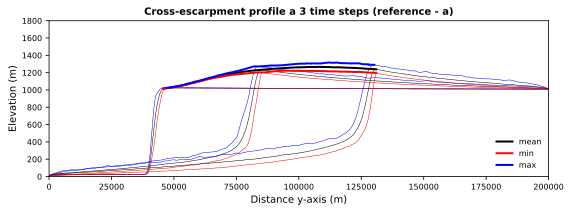

In [9]:
plt.figure(figsize=(8,3))
ax = plt.gca()


k = 1
escpt_mean[k].elevation.plot(lw=0.5,c='k')
escpt_max[k].elevation.plot(lw=0.5,c='b')
escpt_min[k].elevation.plot(lw=0.5,c='r')

k = 30
escpt_mean[k].elevation.plot(lw=0.5,c='k')
escpt_max[k].elevation.plot(lw=0.5,c='b')
escpt_min[k].elevation.plot(lw=0.5,c='r')

k = 74
escpt_mean[k].elevation.plot(lw=0.5,c='k')
escpt_max[k].elevation.plot(lw=0.5,c='b')
escpt_min[k].elevation.plot(lw=0.5,c='r')

val = np.asarray(escpt_pos_mean)
plt.plot(val[:,0],val[:,1],lw=2,c='k',label='mean')
val2 = np.asarray(escpt_pos_min)
plt.plot(val2[:,0],val2[:,1],lw=2,c='r',label='min')
val3 = np.asarray(escpt_pos_max)
plt.plot(val3[1:,0],val3[1:,1],lw=2,c='b',label='max')


plt.xlabel('Distance y-axis (m)', size=10)
plt.ylabel('Elevation (m)', size=10)
plt.title('Cross-escarpment profile a 3 time steps (reference - a)', fontweight='bold', size=10)
plt.ylim(0,1800)
plt.xlim(dataset.y.min(),dataset.y.max())
plt.legend(frameon=False, loc="lower right")
plt.tight_layout()
plt.show()

## Flexural response curve

In [10]:
flex_mean = []
flex_max = []
flex_min = []

for s in range(1,76):
    # Open netcdf data file for the considered time step
    dataset = xr.open_dataset(out_path+'data'+str(s)+'.nc')
    
    # Get escarpment longitudinal profile information
    meands = dataset.mean(dim='x')
    maxds = dataset.max(dim='x')
    minds = dataset.min(dim='x')
    flex_mean.append(meands)
    flex_max.append(maxds)
    flex_min.append(minds)

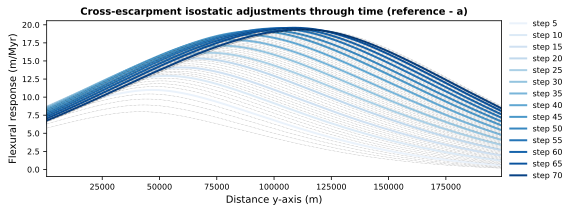

In [11]:
plt.figure(figsize=(8,3))
ax = plt.gca()

cmap = plt.get_cmap('Blues', 76) 

for k in range(1,75):
    val = flex_mean[k].flex-flex_mean[k-1].flex
    val.plot(lw=0.4,ls='-.',c='k',alpha=0.3)
    if k%5 == 0:
        val.plot(lw=2,c=cmap(k),label='step '+str(k))

plt.xlabel('Distance y-axis (m)', size=10)
plt.ylabel('Flexural response (m/Myr)', size=10)
plt.title('Cross-escarpment isostatic adjustments through time (reference - a)', fontweight='bold', size=10)
plt.xlim(dataset.y.min()+750,dataset.y.max()-750)
plt.legend(frameon=False, loc="upper right",bbox_to_anchor=(1.15, 1.05))
plt.tight_layout()
plt.show()